In [1]:
import numpy as np
import os

# Here we have inputed the features for the X dimension fields

In [27]:

#  Load your cleaned terrain layers
base_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/processed'
dem = np.load(os.path.join(base_path, 'dem.npy'))
slope = np.load(os.path.join(base_path, 'slope.npy'))
aspect = np.load(os.path.join(base_path, 'aspect.npy'))


In [28]:
#  Confirm shape match
assert dem.shape == slope.shape == aspect.shape

In [29]:
#  Flatten arrays to 1D
dem_flat = dem.flatten()
slope_flat = slope.flatten()
aspect_flat = aspect.flatten()

In [30]:
#  Filter out invalid (nan) pixels
valid_mask = (~np.isnan(dem_flat)) & (~np.isnan(slope_flat)) & (~np.isnan(aspect_flat))


In [31]:
#  Combine valid pixels into X features
X = np.stack([
    dem_flat[valid_mask],
    slope_flat[valid_mask],
    aspect_flat[valid_mask]
], axis=1)

In [32]:
print(" Input Feature Matrix Shape:", X.shape)
print(" Sample Row: [DEM, Slope, Aspect] =", X[0])

 Input Feature Matrix Shape: (379135, 3)
 Sample Row: [DEM, Slope, Aspect] = [  1.          89.99980229 450.        ]


# Now for the Y dimension 

In [13]:
import fiona

In [33]:
gpkg_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/firepack.gpkg'  # Change path if needed

#To find ou the name of the layer under which fire lables are
print("Layers inside fire_labels.gpkg:")
for layer_name in fiona.listlayers(gpkg_path):
    print("🔹", layer_name)

Layers inside fire_labels.gpkg:
🔹 firepoints


# Full Code: Rasterize .gpkg firepoints → binary label .npy

In [20]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
import os

In [34]:
#  Paths
gpkg_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/firepack.gpkg'  # path to firepoints.gpkg
layer_name = 'firepoints'                # the correct layer name
dem_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/dem_raw.tif'        # path to your DEM raster
output_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/processed/fire_label.npy'  # output label file


##  Step 1: Read the firepoints layer using geopandas

In [22]:
fire_gdf = gpd.read_file(gpkg_path, layer=layer_name)

##  Step 2: Open the DEM raster to match resolution, transform, and shape

In [23]:
with rasterio.open(dem_path) as src:
    dem_shape = src.shape                      # (height, width)
    dem_transform = src.transform              # Affine transform
    dem_crs = src.crs                          # Coordinate Reference System


##  Step 3: Reproject firepoints to DEM's CRS if needed

In [24]:
if fire_gdf.crs != dem_crs:
    fire_gdf = fire_gdf.to_crs(dem_crs)

##  Step 4: Rasterize the firepoints into a binary mask
### Output: numpy array with 1 where firepoint exists, 0 elsewhere

In [25]:
fire_mask = rasterize(
    [(geom, 1) for geom in fire_gdf.geometry],  # convert geometries to (shape, value)
    out_shape=dem_shape,                        # match DEM size
    transform=dem_transform,                    # match DEM geo-location
    fill=0,                                     # default value for "no fire"
    dtype='uint8'                               # small binary format
)

#  Step 5: Save rasterized mask to .npy

In [26]:
np.save(output_path, fire_mask)

#  Step 6: Print stats

In [36]:
print(" Fire label array saved to:", output_path)
print(" Shape:", fire_mask.shape)
print(" Fire pixels (label=1):", np.sum(fire_mask))
print(" Non-fire pixels (label=0):", fire_mask.size - np.sum(fire_mask))

 Fire label array saved to: C:/Users/Siddharth Tomar/forest-fire-simulation/data/processed/fire_label.npy
 Shape: (1194, 676)
 Fire pixels (label=1): 6
 Non-fire pixels (label=0): 807138


# Now bufferign the fire spots and storing data in processed file

In [39]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from shapely.geometry import box

# 📂 Paths
gpkg_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/firepack.gpkg'
layer_name = 'firepoints'
dem_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/dem_raw.tif'
output_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/processed/firepack_buffered.npy'

# 📥 Step 1: Load fire polygons
gdf = gpd.read_file(gpkg_path, layer=layer_name)

# 📥 Step 2: Load DEM metadata
with rasterio.open(dem_path) as src:
    dem_shape = (src.height, src.width)
    dem_transform = src.transform
    dem_crs = src.crs  # Usually EPSG:4326

# ✅ Step 3: Reproject fire polygons to UTM Zone 43N (EPSG:32643)
gdf_projected = gdf.to_crs("EPSG:32643")

# 🔁 Step 4: Buffer geometries outward (in meters)
buffer_distance =800  # You can try 200/300 for stronger effect
gdf_projected['geometry'] = gdf_projected.geometry.buffer(buffer_distance)

# 🔄 Step 5: Reproject back to DEM's CRS
gdf_buffered = gdf_projected.to_crs(dem_crs)

# 🧱 Step 6: Rasterize the buffered polygons
buffered_raster = rasterize(
    [(geom, 1) for geom in gdf_buffered.geometry],
    out_shape=dem_shape,
    transform=dem_transform,
    fill=0,
    dtype='uint8'
)

# 💾 Step 7: Save the final raster label
np.save(output_path, buffered_raster)

# 📊 Step 8: Print summary
print("✅ Buffered fire label saved to:", output_path)
print("📐 Raster shape:", buffered_raster.shape)
print("🔥 Fire pixels after buffer:", np.count_nonzero(buffered_raster))

✅ Buffered fire label saved to: C:/Users/Siddharth Tomar/forest-fire-simulation/data/processed/firepack_buffered.npy
📐 Raster shape: (1194, 676)
🔥 Fire pixels after buffer: 11957


# Program to show fire on DEM map

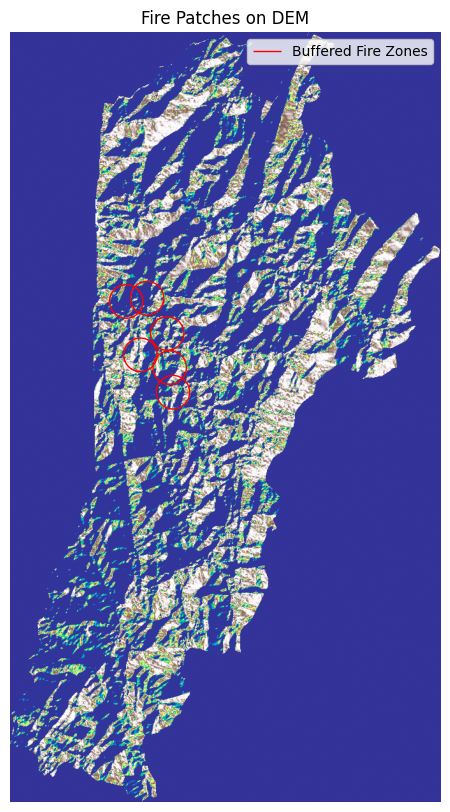

In [41]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import box

# 📂 Paths
gpkg_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/firepack.gpkg'
layer_name = 'firepoints'
dem_path = 'C:/Users/Siddharth Tomar/forest-fire-simulation/data/raw/dem_raw.tif'

# 📥 Load DEM raster
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)
    dem_bounds = src.bounds
    dem_crs = src.crs
    dem_transform = src.transform

# 🔲 Create DEM boundary polygon for plotting
dem_box = gpd.GeoDataFrame({'geometry': [box(*dem_bounds)]}, crs=dem_crs)

# 📥 Load original fire polygons
gdf = gpd.read_file(gpkg_path, layer=layer_name)

# 🔁 Reproject fire polygons to UTM for buffering
gdf_projected = gdf.to_crs("EPSG:32643")

# 📏 Apply buffer
buffer_distance = 800  # Try 150 / 300 / 400 and compare
gdf_projected['geometry'] = gdf_projected.geometry.buffer(buffer_distance)

# 🔁 Reproject buffered fire polygons back to DEM CRS (usually EPSG:4326)
gdf_buffered = gdf_projected.to_crs(dem_crs)

# 🖼️ Plot DEM + fire overlay
fig, ax = plt.subplots(figsize=(10, 10))
show(dem_data, transform=dem_transform, ax=ax, cmap='terrain')
gdf_buffered.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label='Buffered Fire Zones')
plt.title(f"Fire Patches on DEM")
plt.legend()
plt.axis('off')
plt.show()
